In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [98]:
#overview of the dataset
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

In [123]:
images = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images"
tr_lab = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train"
edr = images + "/edr"
mxy = images + "/mxy" # not required
rng = images + "/rng-30m" # not required

In [124]:
edr_files = os.listdir(edr)
trlab_files = os.listdir(tr_lab)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(edr, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (224, 224))
        
        lab_path = os.path.join(tr_lab, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (224, 224), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 1000:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.int64)

# 0 - soil --> 0
# 1 - bedrock --> 1
# 2 - sand --> 2
# 3 - big rock --> 3
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)

(1000, 224, 224, 3) (1000, 224, 224)


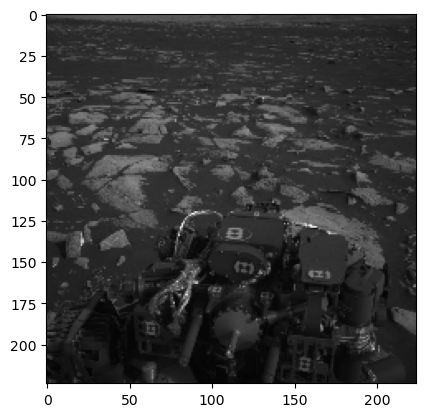

In [5]:
plt.imshow(X[1500])


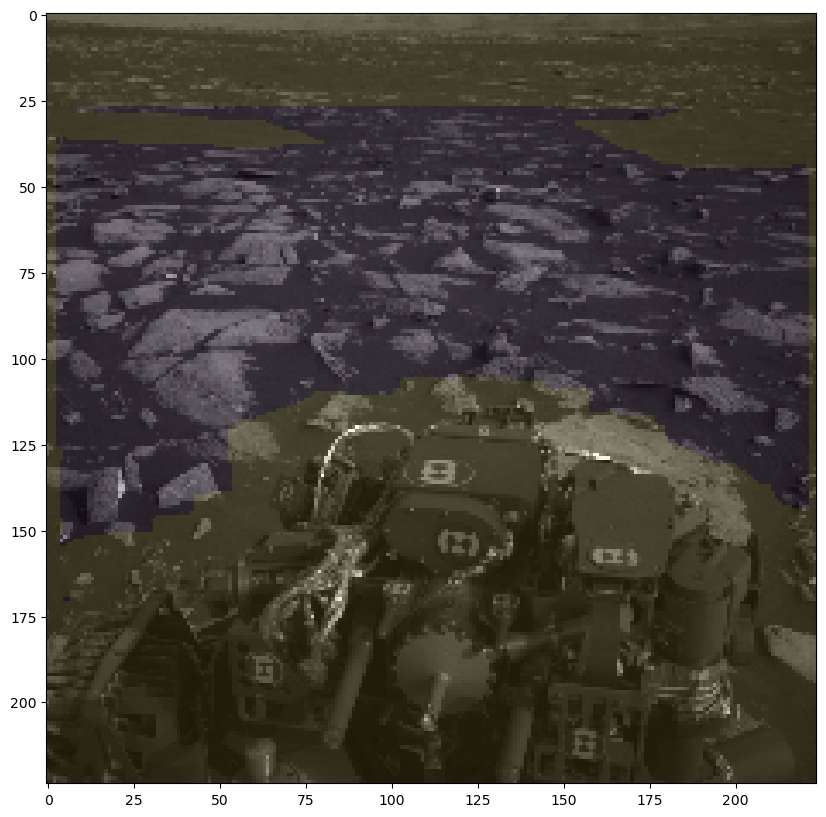

array([1, 4])

In [6]:
#overlay example


index = 1500

plt.figure(figsize = (10, 10))

plt.imshow(X[index])
plt.imshow(y[index], alpha = 0.1)


plt.show()
np.unique(y[index])


In [7]:
#unet implementation: https://github.com/hamdaan19/UNet-Multiclass/blob/main/scripts/model.py

import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF 

class UNET(nn.Module):
    
    def __init__(self, in_channels=3, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

In [8]:
#unet implementation by https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet_Torch(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_Torch, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [9]:
torch.cuda.is_available()

True

In [19]:
#create data batches
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from typing import Union, Iterable, Callable
from sklearn.metrics import f1_score, confusion_matrix
from torch.nn import Softmax
import time
from tqdm import tqdm

class CustomImageDataset(Dataset):
    def __init__(self, X, y, num_classes = 5, transform=None, target_transform=None):
        #self.y = _to_one_hot(y, num_classes)
        self.y = y
        self.X = X
        self.transform = transform
        self.target_transform = target_transform
    

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        
        return self.X[idx], self.y[idx]


    
def evaluate_f1(model, val_loader, lossFunc, num_classes = 5, device = "cuda"):
    
    #list is indexed element-wise corresponding to each class number
    list_of_dicts = []
    f1_scores = []
    targets = []
    predictions = []
    
    for i in range(num_classes):
        list_of_dicts.append(dict())
        
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        print("Validation Phase ...")
        curr_time = time.time()
        for x_i, y_i in tqdm(val_loader):
            x_i = torch.tensor(x_i).clone().detach().permute(0,3,1,2).to(device)
            y_i = torch.tensor(y_i).clone().detach().to(device)
            pred = model(x_i)
            softmax = Softmax(dim=1)
            pred = softmax(pred).argmax(dim=1)

            #compare class-wise TP, FP, TN, FN
            targets.append(y_i.flatten().squeeze())
            predictions.append(pred.flatten().squeeze())
        concat_targets = torch.cat(targets)
        concat_predictions = torch.cat(predictions)

        f1_scores = f1_score(concat_targets.cpu(), concat_predictions.cpu(), average = "weighted")
        confusion = confusion_matrix(concat_targets.cpu(), concat_predictions.cpu())
        print(f1_scores)
        print(confusion)
        print("Time elapsed: "+ str(time.time()-curr_time))
        print("="*20)   
    return f1_scores, confusion

def evaluate_f1_od(model, val_loader, lossFunc, num_classes = 5, device = "cuda"):
    
    #list is indexed element-wise corresponding to each class number
    list_of_dicts = []
    f1_scores = []
    targets = []
    predictions = []
    
    for i in range(num_classes):
        list_of_dicts.append(dict())
        
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        print("Validation Phase ...")
        curr_time = time.time()
        for x_i, y_i in tqdm(val_loader):
            x_i = torch.tensor(x_i).clone().detach().permute(0,3,1,2).to(device)
            y_i = torch.tensor(y_i).clone().detach().to(device)
            pred = model(x_i)
            softmax = Softmax(dim=1)
            pred = softmax(pred["out"]).argmax(dim=1)

            #compare class-wise TP, FP, TN, FN
            targets.append(y_i.flatten().squeeze())
            predictions.append(pred.flatten().squeeze())
        concat_targets = torch.cat(targets)
        concat_predictions = torch.cat(predictions)

        f1_scores = f1_score(concat_targets.cpu(), concat_predictions.cpu(), average = "weighted")
        confusion = confusion_matrix(concat_targets.cpu(), concat_predictions.cpu())
        print(f1_scores)
        print(confusion)
        print("Time elapsed: "+ str(time.time()-curr_time))
        print("="*20)   
    return f1_scores, confusion
                

def K_fold_partition(X, fold = 5):
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = fold)
    
    return kf.split(X)
                
    

def training(model, num_epochs, train_loader, opt, lossFunc,device = "cuda", val_loader = None):
    totalTrainLoss = 0
    
    
    
    
    loss_iter = []
    vali_iter = []
    f1_scores = []
    
    model = model.to(device)
    
    model.train()
    
    

    print("Training Phase ...")
    curr_time = time.time()
    for n in range(num_epochs):
        model.train()
        print("Epoch "+str(n)+": ")
        epoch_loss = 0
        i = 0
        for x_i, y_i in tqdm(train_loader):
            
            #create transformations
        

            x_i = torch.tensor(x_i).clone().detach().permute(0,3,1,2).to(device)
            y_i = torch.tensor(y_i).clone().detach().to(device)
            pred = model(x_i)
            
            loss = lossFunc(pred, y_i.long())

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.detach()

            i += 1
        loss_iter.append(epoch_loss/i)
        print("Cumulative Batch Loss:" +str(epoch_loss)+" Average Loss: " + str(epoch_loss/i))
        print("Time elapsed: "+ str(time.time()-curr_time))
        print("="*20)
        curr_time = time.time()
        
        if val_loader != None:
            f1_scores.append(evaluate_f1(model,val_loader, lossFunc, device = device))
        
    print("training_completed")
    return loss_iter,f1_scores

#if model outputs an ordered_dict
def training_od(model, num_epochs, train_loader, opt, lossFunc,device = "cuda", val_loader = None):
    totalTrainLoss = 0
    
    
    
    
    loss_iter = []
    vali_iter = []
    f1_scores = []
    
    model = model.to(device)
    
    model.train()
    
    

    print("Training Phase ...")
    curr_time = time.time()
    for n in range(num_epochs):
        model.train()
        print("Epoch "+str(n)+": ")
        epoch_loss = 0
        i = 0
        for x_i, y_i in tqdm(train_loader):
            
            #create transformations
        

            x_i = torch.tensor(x_i).clone().detach().permute(0,3,1,2).to(device)
            y_i = torch.tensor(y_i).clone().detach().to(device)
            pred = model(x_i)
            
            loss = lossFunc(pred["out"], y_i.long())

            opt.zero_grad()
            loss.backward()
            opt.step()

            #detach is important here to save RAM usage
            epoch_loss += loss.detach()

            i += 1
        loss_iter.append(epoch_loss/i)
        print("Cumulative Batch Loss:" +str(epoch_loss)+" Average Loss: " + str(epoch_loss/i))
        print("Time elapsed: "+ str(time.time()-curr_time))
        print("="*20)
        curr_time = time.time()
        
        if val_loader != None:
            f1_scores.append(evaluate_f1(model,val_loader, lossFunc, device = device))
        
    print("training_completed")
    return loss_iter,f1_scores

In [ ]:
#official kfold cross-validation training code for unet (using loops, however this is very memory intensive to run)
'''
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
import gc

results = []
models = []
validation_results = []
i=0

#initialize a model and obtain its states
default_model = UNET(classes = 5)
state_dict = UNET(classes=5).state_dict()

partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]

#could also implement a loop here over partitions

for train_indices, test_indices in partitions:

    print("K-Fold iter: "+str(i))

    #reset model
    SegModel = UNET(classes=5)
    SegModel.load_state_dict(state_dict)

    lossFunc = CrossEntropyLoss()

    opt = SGD(SegModel.parameters(), lr= 0.1)


    X_train = X[train_indices]
    X_val = X[test_indices]

    y_train = y[train_indices]
    y_val = y[test_indices]

    train_dataset = CustomImageDataset(X_train, y_train)
    val_dataset = CustomImageDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size = 16)
    val_loader = DataLoader(val_dataset, batch_size = 16)

    train_results = training(SegModel, 10, train_loader, opt, lossFunc)
    
    #validation_results.append(evaluate_f1(SegModel,val_loader,lossFunc))
    
    torch.save(SegModel.state_dict(), "3fold_trial_2000"+str(i)+"_model.pth")
    results.append(train_results)
    models.append(SegModel.state_dict())

    del SegModel
    del opt
    gc.collect()
    
    i+= 1
    
    res = input("Continue to next fold? (y/n)")
    if (res == "y"):
        continue
    else:
        break
       
    
    

In [128]:
#official kfold cross-validation training code for resnet (using loops, however this is very memory intensive to run)

from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
import gc
import copy

results = []
models = []
validation_results = []
i=0

#initialize a model and obtain its states
import torchvision.models.segmentation
n_classes = 5


#if using resnet
default_model = torchvision.models.segmentation.fcn_resnet50()
default_model.classifier[4] = torch.nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
####
'''

#if using unet
default_model = UNet_Torch(n_channels = 3,n_classes = 5)
####
'''

#everything below can be kept the same
state_dict = default_model.state_dict()

partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]

#could also implement a loop here over partitions

for train_indices, test_indices in partitions:

    print("K-Fold iter: "+str(i))

    #reset model
    
    gc.collect()
    
    SegModel = copy.deepcopy(default_model)
    SegModel.load_state_dict(state_dict)

    lossFunc = CrossEntropyLoss(ignore_index = 4)

    opt = SGD(SegModel.parameters(), lr= 0.05)


    X_train = X[train_indices]
    X_val = X[test_indices]

    y_train = y[train_indices]
    y_val = y[test_indices]

    train_dataset = CustomImageDataset(X_train, y_train)
    val_dataset = CustomImageDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size = 16)
    val_loader = DataLoader(val_dataset, batch_size = 16)
    
    
    #if resnet
    train_results = training_od(SegModel, 5, train_loader, opt, lossFunc)
    '''

    #if unet
    train_results = training(SegModel, 10, train_loader, opt, lossFunc)
    '''
    
    
    
    torch.save(SegModel.state_dict(), "resnet_ignore"+str(i)+"_model.pth")
    results.append(train_results)
    models.append(SegModel.state_dict())
    
    evaluate_f1_od(SegModel,val_loader,lossFunc)

    del SegModel
    gc.collect()
    
    i+= 1
    
    res = input("Continue to next fold? (y/n)")
    if (res == "y"):
        continue
    else:
        break

K-Fold iter: 0
Training Phase ...
Epoch 0: 


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:34<00:00,  1.20it/s]


Cumulative Batch Loss:tensor(22.6363, device='cuda:0') Average Loss: tensor(0.5390, device='cuda:0')
Time elapsed: 35.361002683639526
Epoch 1: 


100%|██████████| 42/42 [00:34<00:00,  1.20it/s]


Cumulative Batch Loss:tensor(7.9902, device='cuda:0') Average Loss: tensor(0.1902, device='cuda:0')
Time elapsed: 35.32447528839111
Epoch 2: 


100%|██████████| 42/42 [00:34<00:00,  1.22it/s]


Cumulative Batch Loss:tensor(3.8852, device='cuda:0') Average Loss: tensor(0.0925, device='cuda:0')
Time elapsed: 34.9635055065155
Epoch 3: 


100%|██████████| 42/42 [00:34<00:00,  1.21it/s]


Cumulative Batch Loss:tensor(2.1563, device='cuda:0') Average Loss: tensor(0.0513, device='cuda:0')
Time elapsed: 35.22238326072693
Epoch 4: 


100%|██████████| 42/42 [00:34<00:00,  1.21it/s]


Cumulative Batch Loss:tensor(1.4418, device='cuda:0') Average Loss: tensor(0.0343, device='cuda:0')
Time elapsed: 35.11710453033447
training_completed
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.29it/s]


0.3652137761896818
[[3416512  220260   95720     848       0]
 [ 155090 4007453   86291   11491       0]
 [  65437   46639  990191    2863       0]
 [   7604   43591   13385   25696       0]
 [2072491 3141408 2135842  219972       0]]
Time elapsed: 12.211539030075073


KeyboardInterrupt: Interrupted by user

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
import gc
import copy

results = []
models = []
validation_results = []
i=0

#initialize a model and obtain its states
default_model = unet_model

state_dict = default_model.state_dict()

partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]

In [ ]:

#could also implement a loop here over partitions

train_indices, test_indices = partitions[0] #first partition

#reset model
SegModel = copy.deepcopy(default_model)
SegModel.load_state_dict(state_dict)

lossFunc = CrossEntropyLoss()

opt = SGD(SegModel.parameters(), lr= 0.1)


X_train = X[train_indices]
X_val = X[test_indices]

y_train = y[train_indices]
y_val = y[test_indices]

train_dataset = CustomImageDataset(X_train, y_train)
val_dataset = CustomImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size = 16)

train_results = training(SegModel, 10, train_loader, opt, lossFunc)

#validation_results.append(evaluate_f1(SegModel,val_loader,lossFunc))

torch.save(SegModel.state_dict(), "3fold_trial_2000"+str(i)+"_model.pth")
results.append(train_results)
models.append(SegModel.state_dict())

del SegModel
del opt
gc.collect()

i+= 1



In [ ]:
#could also implement a loop here over partitions

train_indices, test_indices = partitions[1] #second partition

#reset model
SegModel = copy.deepcopy(default_model)
SegModel.load_state_dict(state_dict)

lossFunc = CrossEntropyLoss()

opt = SGD(SegModel.parameters(), lr= 0.1)


X_train = X[train_indices]
X_val = X[test_indices]

y_train = y[train_indices]
y_val = y[test_indices]

train_dataset = CustomImageDataset(X_train, y_train)
val_dataset = CustomImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size = 16)

train_results = training(SegModel, 10, train_loader, opt, lossFunc)

#validation_results.append(evaluate_f1(SegModel,val_loader,lossFunc))

torch.save(SegModel.state_dict(), "3fold_trial_2000"+str(i)+"_model.pth")
results.append(train_results)
models.append(SegModel.state_dict())

del SegModel
del opt
gc.collect()

i+= 1

In [ ]:
#could also implement a loop here over partitions

train_indices, test_indices = partitions[2] #third partition

#reset model
SegModel = copy.deepcopy(default_model)
SegModel.load_state_dict(state_dict)

lossFunc = CrossEntropyLoss()

opt = SGD(SegModel.parameters(), lr= 0.1)


X_train = X[train_indices]
X_val = X[test_indices]

y_train = y[train_indices]
y_val = y[test_indices]

train_dataset = CustomImageDataset(X_train, y_train)
val_dataset = CustomImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size = 16)

train_results = training(SegModel, 10, train_loader, opt, lossFunc)

#validation_results.append(evaluate_f1(SegModel,val_loader,lossFunc))

torch.save(SegModel.state_dict(), "3fold_trial_2000"+str(3)+"_model.pth")
results.append(train_results)
models.append(SegModel.state_dict())

del SegModel
del opt
gc.collect()

i+= 1

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
[1 2 4]
0.6777630054799703


<Figure size 640x480 with 0 Axes>

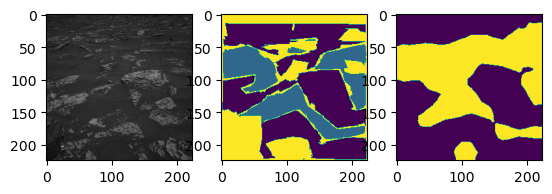

<Figure size 1000x1000 with 0 Axes>

In [127]:
#Make one prediction

#create data batches
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from typing import Union, Iterable, Callable
from sklearn.metrics import f1_score, confusion_matrix
from torch.nn import Softmax
import time
from tqdm import tqdm

plt.figure()

i = 77

f, axarr = plt.subplots(1,3) 


plt.figure(figsize = (10, 10))

file_name = "unet_3fold_trial_20002_model.pth"

'''
model = UNet_Torch(n_channels = 3, n_classes = 5)
model.load_state_dict(torch.load(os.path.join(dir_path,file_name)))
'''

model = SegModel
model.to("cuda")
model.eval()


prediction = model(torch.tensor(X[i])[None,:,:,:].permute(0,3,1,2).to("cuda"))


prediction = prediction["out"]


softmax = Softmax()

softmax = Softmax(dim=1)

prediction = softmax(prediction).argmax(dim=1)

print(prediction.flatten())
print(np.unique(y[i].flatten()))

print(f1_score(prediction.flatten().cpu(), y[i].flatten(), average = "weighted"))

axarr[0].imshow((torch.tensor(X[i])))

axarr[1].imshow(y[i])

axarr[2].imshow(prediction.squeeze().cpu())

plt.show()

In [ ]:
for i, model_state in enumerate(models):
    torch.save(model_state, "3fold_trial_"+str(i)+"_model.pth")

In [18]:
#validation on validation sets using KFold on UNet_Torch models
dir_path = "/kaggle/input/unet-resnet-models"
file_names = ["unet_3fold_trial_20000_model.pth","unet_3fold_trial_20001_model.pth","unet_3fold_trial_20002_model.pth"]
partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]
for i, (_, test_indices) in enumerate(partitions):
    print("fold: "+ str(i))
    val_X = X[test_indices]
    val_y = y[test_indices]

    print(val_y.shape)

    val_dataset = CustomImageDataset(val_X, val_y)
    val_loader= DataLoader(val_dataset, batch_size = 16)

    #load the model
    model = UNet_Torch(n_channels = 3, n_classes = 5)
    model.load_state_dict(torch.load(os.path.join(dir_path,file_names[i])))
    model.to("cuda")


    #evaluate the f1_score

    f1, c = evaluate_f1(model, val_loader, None)

fold: 0
(667, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:15<00:00,  2.76it/s]


0.6236832535728103
[[ 3065378   547553  2303832        0  1239341]
 [  274064  3889421   161466        0  4544762]
 [   43799    81786  1086404        0   931955]
 [     286    30995      805        0   149351]
 [  427177   851999   699133        0 13137885]]
Time elapsed: 29.884057760238647
fold: 1
(667, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:15<00:00,  2.73it/s]


0.5813571796874109
[[ 3585400   915224  1125990        0  1335686]
 [  605712  2647709   308391        0  5451160]
 [   12826   117848   916405        0  1318658]
 [    1487    14567      413        0   143343]
 [  484707   782596   568595        0 13130675]]
Time elapsed: 29.999958038330078
fold: 2
(666, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:15<00:00,  2.69it/s]


0.6530958703287253
[[ 5023305   247143   440291        0  1694184]
 [  159719  3460344    43526        0  5473004]
 [   56207    86495   654063        0  1360623]
 [     369    11461        9        0   158221]
 [  414551   575244   171862        0 13386595]]
Time elapsed: 30.174510955810547


In [23]:
#validation on validation sets using KFold on FCN models
import torchvision

dir_path = "/kaggle/input/unet-resnet-models"
file_names = ["resnet_3fold_trial_20000_model.pth","resnet_3fold_trial_20001_model.pth","resnet_3fold_trial_20002_model.pth"]
partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]
for i, (_, test_indices) in enumerate(partitions):
    print("fold: "+ str(i))
    val_X = X[test_indices]
    val_y = y[test_indices]

    print(val_y.shape)

    val_dataset = CustomImageDataset(val_X, val_y)
    val_loader= DataLoader(val_dataset, batch_size = 16)

    #load the model
    model = torchvision.models.segmentation.fcn_resnet50()
    model.classifier[4] = torch.nn.Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
    model.load_state_dict(torch.load(os.path.join(dir_path,file_names[i])))
    model.to("cuda")


    #evaluate the f1_score

    f1, c = evaluate_f1_od(model, val_loader, None)

fold: 0
(667, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:10<00:00,  4.17it/s]


0.8238366452421834
[[ 6605981   117162    17840       19   415102]
 [  350126  7735378    26052     5259   752898]
 [  218435    73048  1503362     2991   346108]
 [    3524    71676     6350    13887    86000]
 [ 1583343  1452857   285659    10986 11783349]]
Time elapsed: 24.34587335586548
fold: 1
(667, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:10<00:00,  4.14it/s]


0.8296345359067221
[[ 6070909    72648    48226      160   770357]
 [  246239  7285102    26250     2026  1453355]
 [   67591    44287  1741196     1714   510949]
 [    2738    58013     1252    11767    86040]
 [  929216  1105249   209219     6812 12716077]]
Time elapsed: 24.178947925567627
fold: 2
(666, 224, 224)
Validation Phase ...


  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 42/42 [00:10<00:00,  4.18it/s]


0.8303533504654675
[[ 6204153   168299    26954        0  1005517]
 [   55815  7896021    11275     2689  1170793]
 [   44275    74830  1497465     1357   539461]
 [    2350    51171     2733     8366   105440]
 [  702657  1455033   174742    11275 12204545]]
Time elapsed: 23.988476276397705


In [ ]:
#validation using KFold
file_name = "3fold_trial_20001_model.pth"
partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]
_ , test_indices = partitions[1]
val_X = X[test_indices]
val_y = y[test_indices]

val_dataset = CustomImageDataset(val_X, val_y)
val_loader= DataLoader(val_dataset, batch_size = 16)

#load the model
model = UNET(classes = 5)
model.load_state_dict(torch.load(os.path.join(dir_path,file_name)))
model.to("cuda")


#evaluate the f1_score

f1 = evaluate_f1(model, val_loader, None)

In [ ]:
file_name = "3fold_trial_20003_model.pth"
partitions = [(x, y) for x,y in K_fold_partition(X, fold = 3)]
_ , test_indices = partitions[2]
val_X = X[test_indices]
val_y = y[test_indices]

val_dataset = CustomImageDataset(val_X, val_y)
val_loader= DataLoader(val_dataset, batch_size = 16)

#load the model
model = UNET(classes = 5)
model.load_state_dict(torch.load(os.path.join(dir_path,file_name)))
model.to("cuda")


#evaluate the f1_score

f1 = evaluate_f1(model, val_loader, None)

In [108]:
#test data prediction from gold_standards

images = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images"
tr_lab = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/test"
edr = images + "/edr"

edr_files = os.listdir(edr)
trlab_files = os.listdir(tr_lab)


X_list_gold = []
y_list_gold = []

c = 0

# preparing X_test and y_test
for i, lab_dir in enumerate(trlab_files):
    X_test = []
    y_test = []
    for j, lab_name in enumerate(os.listdir(os.path.join(tr_lab,lab_dir))):
        img_name = lab_name[:-11] + ".JPG"
        
        if img_name in edr_files:

            img_path = os.path.join(edr, img_name)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, dsize = (224, 224))

            lab_path = os.path.join(tr_lab, lab_dir,lab_name)

            lab_arr = cv2.imread(lab_path, 0)

            lab_arr = cv2.resize(lab_arr, (224, 224), interpolation = cv2.INTER_NEAREST)

            X_test.append(img_arr)
            y_test.append(lab_arr)
    
    X_list_gold.append(X_test)
    y_list_gold.append(y_test)

    
for i, X_test in enumerate(X_list_gold):
    X_list_gold[i] = np.asarray(X_test, dtype = np.float32) / 255.0
    
for i, y_test in enumerate(y_list_gold):
    y_list_gold[i] = np.array(y_test, dtype = np.int64)
    y_list_gold[i][y_list_gold[i]==255] = 4

# 0 - soil --> 0
# 1 - bedrock --> 1
# 2 - sand --> 2
# 3 - big rock --> 3
# 255 -> 4 - NULL (no label)


In [48]:
#perform validation on each test set

dir_path = "/kaggle/input/unet-resnet-models"
unet_weight_file = "unet_3fold_trial_20002_model.pth"
fcn_weight_file = "resnet_3fold_trial_20002_model.pth"

best_unet = UNet_Torch(n_channels = 3, n_classes = 5)
best_unet.load_state_dict(torch.load(os.path.join(dir_path, unet_weight_file)))
best_unet.to("cuda")

best_fcn = torchvision.models.segmentation.fcn_resnet50()
best_fcn.classifier[4] = torch.nn.Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
best_fcn.load_state_dict(torch.load(os.path.join(dir_path,fcn_weight_file)))
best_fcn.to("cuda")

for test_X, test_y in list(zip(X_list_gold, y_list_gold)):
    #create dataset
    test_dataset = CustomImageDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size = 16)
    
    u_f1, u_c = evaluate_f1(best_unet, test_loader, None)
    fcn_f1, fcn_c =evaluate_f1_od(best_fcn, test_loader, None)
    

Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


0.7177796648553433
[[2004270   41229  321180       0  508546]
 [  52119  592208    3301       0  605643]
 [  15171   16362  626732       0  807960]
 [      0       0      69       0    3651]
 [ 928898  982632  319307       0 8327394]]
Time elapsed: 14.1989266872406
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.23it/s]


0.7298629825331133
[[2515752   20370   98060       0  241043]
 [  13473 1141836     355     114   97493]
 [   2184   34581 1269810     437  159213]
 [     28     728       0     523    2441]
 [1333564 2220058  405443   11110 6588056]]
Time elapsed: 11.92516541481018
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


0.6907004979550075
[[2498686   77573  401219       0  862461]
 [ 103940  918693   11429       0 1106884]
 [  18233   34218  715100       0 1067097]
 [     89      18      98       0    6019]
 [ 379510  601929  142743       0 7210733]]
Time elapsed: 14.405993461608887
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


0.7917075516730057
[[3233759   68339  110542      12  427287]
 [  41548 1839811    4209    2545  252833]
 [   3811   81192 1486783     961  261901]
 [    179    1021     111     699    4214]
 [ 585704 1427210  172023    7967 6142011]]
Time elapsed: 11.640883207321167
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


0.6449948066190269
[[2571776  133997  433034       0 1124360]
 [ 141751 1147865   14927       0 1567307]
 [  19498   80550  742235       0 1300366]
 [    241    1041     119       0   16846]
 [ 267192  268978   80274       0 6244315]]
Time elapsed: 14.318150758743286
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


0.8059010539941066
[[3389974  162837  118330     129  591897]
 [  65063 2377030    9908    3874  415975]
 [   6189  190692 1556271    1546  387951]
 [   1494    4750     266    1340   10397]
 [ 402281  682264   88893    5295 5682026]]
Time elapsed: 11.563255548477173


In [109]:
#perform validation on each test set using the small model

dir_path = "/kaggle/input/small-models"
unet_weight_file = "unet_3fold_trial_10000_model.pth"
fcn_weight_file = "resnet_3fold_trial_10000_model.pth"

small_unet = UNet_Torch(n_channels = 3, n_classes = 5)
small_unet.load_state_dict(torch.load(os.path.join(dir_path, unet_weight_file)))
small_unet.to("cuda")

small_fcn = torchvision.models.segmentation.fcn_resnet50()
small_fcn.classifier[4] = torch.nn.Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
small_fcn.load_state_dict(torch.load(os.path.join(dir_path,fcn_weight_file)))
small_fcn.to("cuda")

for test_X, test_y in list(zip(X_list_gold, y_list_gold)):
    #create dataset
    test_dataset = CustomImageDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size = 16)
    
    u_f1, u_c = evaluate_f1(small_unet, test_loader, None)
    fcn_f1, fcn_c =evaluate_f1_od(small_fcn, test_loader, None)
    

Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


0.6066449611540814
[[ 617332 1771634  105367       0  380892]
 [   3186  922917    7249       0  319919]
 [   7188  123934  456506       0  878597]
 [      0     797       0       0    2923]
 [ 217562 2673397  347740       0 7319532]]
Time elapsed: 14.264965534210205
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


0.7071156871846342
[[2529711   59279   92660     340  193235]
 [  23966 1147661    2206      92   79346]
 [   3156   44697 1302727     523  115122]
 [    105    1047       1    1681     886]
 [1485019 2312913  574471   14240 6171588]]
Time elapsed: 11.628184795379639
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


0.5604735719446927
[[ 771399 2283353  150657       0  634530]
 [  13155 1473841   33487       0  620463]
 [   7236  174021  509526       0 1143865]
 [      5    1640      53       0    4526]
 [  53473 1559824  223139       0 6498479]]
Time elapsed: 14.701920747756958
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


0.7778352059119684
[[3255511  131072  116275     620  336461]
 [  71653 1846938   16337    3441  202577]
 [   5731   91906 1543058    1272  192681]
 [    511    1312     495    2059    1847]
 [ 708551 1494369  295900    9484 5826611]]
Time elapsed: 11.84141230583191
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


0.5194117209046075
[[ 784553 2500063  171309       0  807242]
 [  18836 1878482   56927       0  917605]
 [   7745  235765  532066       0 1367073]
 [     13    6260     185       0   11789]
 [  34121  872109  156375       0 5798154]]
Time elapsed: 15.058427810668945
Validation Phase ...


  0%|          | 0/21 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


0.8028792410284467
[[3430993  244529  137593    1204  448848]
 [ 115982 2388571   29762    4527  333008]
 [   9636  200186 1642860    2261  287706]
 [   2197    3900     993    2508    8649]
 [ 483149  728411  160857    6376 5481966]]
Time elapsed: 11.77490496635437


<Figure size 640x480 with 0 Axes>

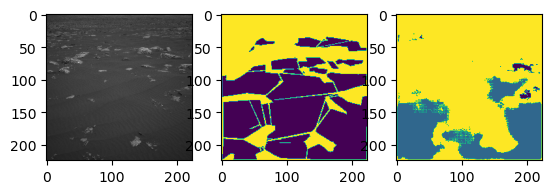

<Figure size 1000x1000 with 0 Axes>

In [94]:
#Make one prediction on gold test set

#create data batches
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from typing import Union, Iterable, Callable
from sklearn.metrics import f1_score, confusion_matrix
from torch.nn import Softmax
import time
from tqdm import tqdm

plt.figure()

i = 99 #between 0 and 322

j = 0 # between 0 and 2

X_testing = X_list_gold[j]
y_testing = y_list_gold[j]

f, axarr = plt.subplots(1,3) 

plt.figure(figsize = (10, 10))

model = best_unet


prediction = model(torch.tensor(X_testing[i])[None,:,:,:].permute(0,3,1,2).to("cuda"))


prediction = prediction


softmax = Softmax()

softmax = Softmax(dim=1)

prediction = softmax(prediction).argmax(dim=1)


axarr[0].imshow((torch.tensor(X_testing[i])))

axarr[1].imshow(y_testing[i])

axarr[2].imshow(prediction.squeeze().cpu())

plt.show()

<Figure size 640x480 with 0 Axes>

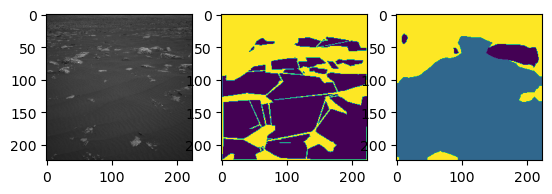

<Figure size 1000x1000 with 0 Axes>

In [97]:
#Make one prediction on gold test set

#create data batches
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from typing import Union, Iterable, Callable
from sklearn.metrics import f1_score, confusion_matrix
from torch.nn import Softmax
import time
from tqdm import tqdm

plt.figure()

i = 99 #between 0 and 322

j = 0 # between 0 and 2

X_testing = X_list_gold[j]
y_testing = y_list_gold[j]

f, axarr = plt.subplots(1,3) 

plt.figure(figsize = (10, 10))

model = best_fcn


prediction = model(torch.tensor(X_testing[i])[None,:,:,:].permute(0,3,1,2).to("cuda"))


prediction = prediction["out"]


softmax = Softmax()

softmax = Softmax(dim=1)

prediction = softmax(prediction).argmax(dim=1)


axarr[0].imshow((torch.tensor(X_testing[i])))

axarr[1].imshow(y_testing[i])

axarr[2].imshow(prediction.squeeze().cpu())

plt.show()

In [119]:
unet_confusion_gold3 = np.array([[2571776,133997,433034,0],[141751,1147865,14927,0],[  19498,   80550,  742235,       0],[    241,    1041,     119,       0]])
unet_confusion_gold3 / unet_confusion_gold3.astype(np.float).sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


array([[8.19348243e-01, 1.02715664e-01, 5.14119364e-01, 0.00000000e+00],
       [4.51607888e-02, 8.79898171e-01, 1.77220720e-02, 0.00000000e+00],
       [6.21191427e-03, 6.17457608e-02, 8.81218070e-01, 0.00000000e+00],
       [7.67807642e-05, 7.97980596e-04, 1.41282681e-04, 0.00000000e+00]])

In [120]:
fcn_confusion_gold3 = np.array([[3389974,  162837,  118330,     129  ],
 [  65063, 2377030,    9908,    3874  ],
 [   6189,  190692, 1556271,    1546  ],
 [   1494,    4750,     266,    1340   ]
 ])
fcn_confusion_gold3 / fcn_confusion_gold3.astype(np.float).sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


array([[9.23379103e-01, 6.63050847e-02, 6.74361058e-02, 1.64331210e-02],
       [1.77222051e-02, 9.67895353e-01, 5.64655570e-03, 4.93503185e-01],
       [1.68579265e-03, 7.76472744e-02, 8.86916723e-01, 1.96942675e-01],
       [4.06943646e-04, 1.93413753e-03, 1.51593038e-04, 1.70700637e-01]])

In [129]:
dummy_model = UNet_Torch(n_channels = 3, n_classes = 5)


In [130]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(dummy_model)

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|          inc.double_conv.0.weight         |    1728    |
|          inc.double_conv.1.weight         |     64     |
|           inc.double_conv.1.bias          |     64     |
|          inc.double_conv.3.weight         |   36864    |
|          inc.double_conv.4.weight         |     64     |
|           inc.double_conv.4.bias          |     64     |
| down1.maxpool_conv.1.double_conv.0.weight |   73728    |
| down1.maxpool_conv.1.double_conv.1.weight |    128     |
|  down1.maxpool_conv.1.double_conv.1.bias  |    128     |
| down1.maxpool_conv.1.double_conv.3.weight |   147456   |
| down1.maxpool_conv.1.double_conv.4.weight |    128     |
|  down1.maxpool_conv.1.double_conv.4.bias  |    128     |
| down2.maxpool_conv.1.double_conv.0.weight |   294912   |
| down2.maxpool_conv.1.double_conv.1.weight |    256    

31037893

In [131]:
dummy_model = torchvision.models.segmentation.fcn_resnet50()
dummy_model.classifier[4] = torch.nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
count_parameters(dummy_model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|         backbone.conv1.weight         |    9408    |
|          backbone.bn1.weight          |     64     |
|           backbone.bn1.bias           |     64     |
|     backbone.layer1.0.conv1.weight    |    4096    |
|      backbone.layer1.0.bn1.weight     |     64     |
|       backbone.layer1.0.bn1.bias      |     64     |
|     backbone.layer1.0.conv2.weight    |   36864    |
|      backbone.layer1.0.bn2.weight     |     64     |
|       backbone.layer1.0.bn2.bias      |     64     |
|     backbone.layer1.0.conv3.weight    |   16384    |
|      backbone.layer1.0.bn3.weight     |    256     |
|       backbone.layer1.0.bn3.bias      |    256     |
| backbone.layer1.0.downsample.0.weight |   16384    |
| backbone.layer1.0.downsample.1.weight |    256     |
|  backbone.layer1.0.downsample.1.bias  |    256     |
|     back

32948805